# DATA20001 Deep Learning - Group Project
## Image project

**Due Wednesday December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imageio.imread`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- Loading all the images into one big matrix as we have done in the exercises is not feasible (e.g. the virtual servers in CSC have only 3 GB of RAM). You need to load the images in smaller chunks for the training. This shouldn't be a problem we are doing mini-batch training anyway, and thus we don't need to keep all the images in memory. You can simply pass you current chunk of images to `model.fit()` as it remembers the weights from the previous run.

- You need to think carefully about how you load the annotations and match them up with the corresponding images, especially as you are loading them in smaller chunks.

## Download the data

In [1]:
from keras.utils.data_utils import get_file

database_path = 'train/'

dl_file='dl2017-image-proj.zip'
dl_url='https://www.cs.helsinki.fi/u/mvsjober/misc/'
get_file(dl_file, dl_url+dl_file, cache_dir='./', cache_subdir=database_path, extract=True)

Using TensorFlow backend.


279371776/279523357 [============================>.] - ETA: 0s

'./train/dl2017-image-proj.zip'

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

### Import

In [2]:
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import *
from keras.preprocessing.image import *
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from scipy import misc
from sklearn.metrics import f1_score
from IPython.display import SVG

### Pre-process

In [3]:
class_indices = {0:"baby",
                 1:"bird",
                 2:"car",
                 3:"clouds",
                 4:"dog",
                 5:"female",
                 6:"flower",
                 7:"male",
                 8:"night",
                 9:"people",
                 10:"portrait",
                 11:"river",
                 12:"sea",
                 13:"tree"}

#### Label and file name loading

In [4]:
N = 20000
num_class = len(class_indices)


img_list = [database_path+"images/"+"im"+str(x)+".jpg" for x in range(1,N+1)]
y = np.zeros((N,num_class))

for k,v in class_indices.items():
    with open(database_path+"annotations/"+v+".txt","r") as fp:
        for line in fp:
            y[int(line)-1,k] = 1

#### Loading dataset

In [5]:
img_size = (32,32)

image_load_func = lambda path: misc.imresize(misc.imread(path,mode="RGB"),size=img_size)

male
people


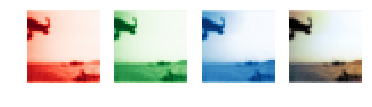

In [6]:
example=3
img = image_load_func(img_list[example])
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]
for l in range(3):
    plt.subplot(1, 4, l+1)
    plt.imshow(img[:,:,l],cmap=cmaps[l])
    plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(img)
plt.axis('off')

if sum(y[example]==1)==0:
    print("No label")
else:
    for i in np.argwhere(y[example]==1).flatten():
        print(class_indices[i])

In [7]:
X = np.stack([image_load_func(file) for file in img_list])
print(X.shape)

(20000, 32, 32, 3)


### Model Building

In [8]:
from densenet import *

In [9]:
def getThreshold(y_pred,y_true,threshold_interval):
    threshold = np.arange(0,1,threshold_interval)

    best_threshold = np.zeros(y_true.shape[1])
    for i in range(y_pred.shape[1]):
        temp = np.array([[1 if pred>j else 0 for j in threshold] for pred in y_pred[:,i]])
        score = np.array([f1_score(y_true[:,i],temp[:,j], average='micro') for j in range(len(threshold)) ])
        best_threshold[i] = threshold[score.argmax()]
        print("Best threshold for class",i,"：",best_threshold[i])
    return best_threshold

In [53]:
import pickle
kf = KFold(n_splits=5,shuffle=True)
split = []
for train,val in kf.split(X,y):
    split.append({"train":train,"val":val})
pickle.dump(split, open( "kf.p", "wb"))

In [57]:
import pickle
 
split = pickle.load(open( "kf.p", "rb" ) )

print(split[0]["train"])

[    0     1     2 ..., 19996 19998 19999]


#### Simple DenseNet with minor adjustment

In [10]:
#hyper-parameter
nb_filter=32
nb_dense_block=1
nb_layers=3
growth_rate=24
dropout_rate=0.3
weight_decay=0

In [11]:
K.clear_session()
dn = DenseNet(num_class, X.shape[1:], nb_layers*3+4, nb_dense_block, growth_rate,
             nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay)
dn.compile(loss='binary_crossentropy', 
              optimizer='adam')

print(dn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 32, 32, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32, 32, 32)    128         initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

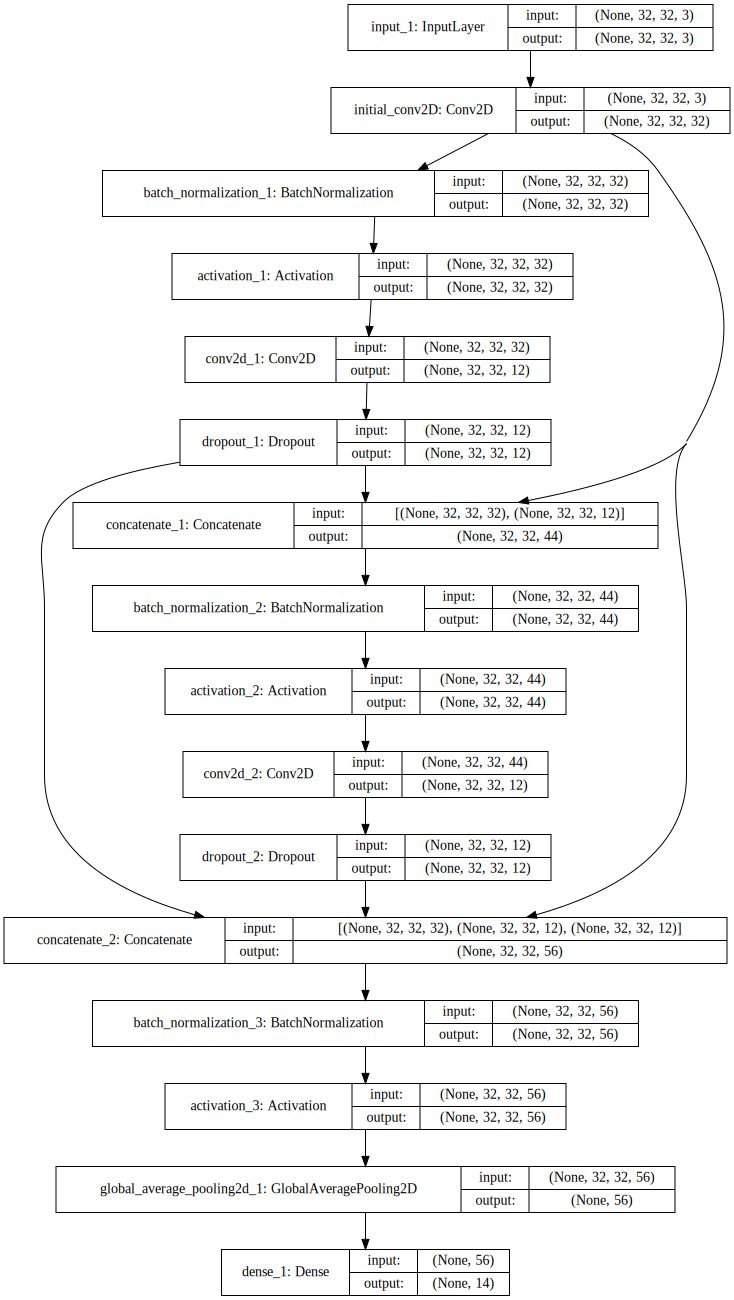

In [41]:
SVG(model_to_dot(dn, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
%%time

epochs = 3

history = dn.fit(X,y,epochs=epochs,batch_size=64,verbose=1)

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

In [12]:
%%time

epochs = 10
#5-fold cross validation
score = []
kf = KFold(n_splits=5,shuffle=True)
for train,val in kf.split(X, y):
    K.clear_session()
    dn = DenseNet(num_class, X.shape[1:], nb_layers*3+4, nb_dense_block, growth_rate,
             nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay)
    dn.compile(loss='binary_crossentropy', optimizer='adam')
    dn.fit(X[train],y[train],epochs=epochs,batch_size=64,verbose=1)
    y_train_pred = dn.predict(X[train],batch_size=32, verbose=1)
    threshold=getThreshold(y_train_pred,y[train],0.001)
    y_val_pred = 1*(dn.predict(X[val],batch_size=32, verbose=1)>threshold)    
    score.append(f1_score(y[val], y_val_pred, average='micro'))
    print("F1 Score:",score[-1])

Epoch 1/10
16000/16000 [==============================] - 438s - loss: 0.2339   
Epoch 2/10
16000/16000 [==============================] - 551s - loss: 0.1897   
Epoch 3/10
16000/16000 [==============================] - 431s - loss: 0.1759   
Epoch 4/10
16000/16000 [==============================] - 443s - loss: 0.1637   
Epoch 5/10
16000/16000 [==============================] - 434s - loss: 0.1523   
Epoch 6/10
16000/16000 [==============================] - 434s - loss: 0.1415   
Epoch 7/10
16000/16000 [==============================] - 435s - loss: 0.1296   
Epoch 8/10
16000/16000 [==============================] - 435s - loss: 0.1164   
Epoch 9/10
16000/16000 [==============================] - 438s - loss: 0.1056   
Epoch 10/10
16000/16000 [==============================] - 237s   
Best threshold for class 0 ： 0.045
Best threshold for class 1 ： 0.095
Best threshold for class 2 ： 0.099
Best threshold for class 3 ： 0.351
Best threshold for class 4 ： 0.11
Best threshold for class 5 ： 0

In [13]:
print("F1 Score:", np.mean(score),"+/-", np.std(score))

F1 Score: 0.363521563009 +/- 0.00418789791906


#### Customized DenseNet

In [10]:
def getCutmoizedDenseNet():
    weight_decay=0.00001
    dropout_rate=0.2
    growth_rate=12
    
    K.clear_session()
    model_input = Input(shape=X.shape[1:])

    x = Conv2D(32, (3, 3),
                   kernel_initializer="he_uniform",
                   padding="same",
                   name="initial_conv2D",
                   use_bias=True,
                   kernel_regularizer=l2(weight_decay))(model_input)
    
    #blocks
    x, nb_filter = denseblock(x, 2, 32, growth_rate,dropout_rate=dropout_rate)
    x = transition(x, nb_filter, dropout_rate=dropout_rate,weight_decay=weight_decay)# add transition
    

    #last block 
    x, nb_filter = denseblock(x, 2, 64, growth_rate,dropout_rate=dropout_rate,weight_decay=weight_decay)

    x = BatchNormalization(axis=1,gamma_regularizer=l2(weight_decay),beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = AveragePooling2D()(x)
    
    #more layers
    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    model_output = Dense(num_class, activation='sigmoid')(x)

    model = Model(inputs=[model_input], outputs=[model_output], name="DenseNet")
    
    return model

In [11]:
cdn=getCutmoizedDenseNet()
cdn.compile(loss='binary_crossentropy', optimizer='adam')

print(cdn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 32, 32, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32, 32, 32)    128         initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

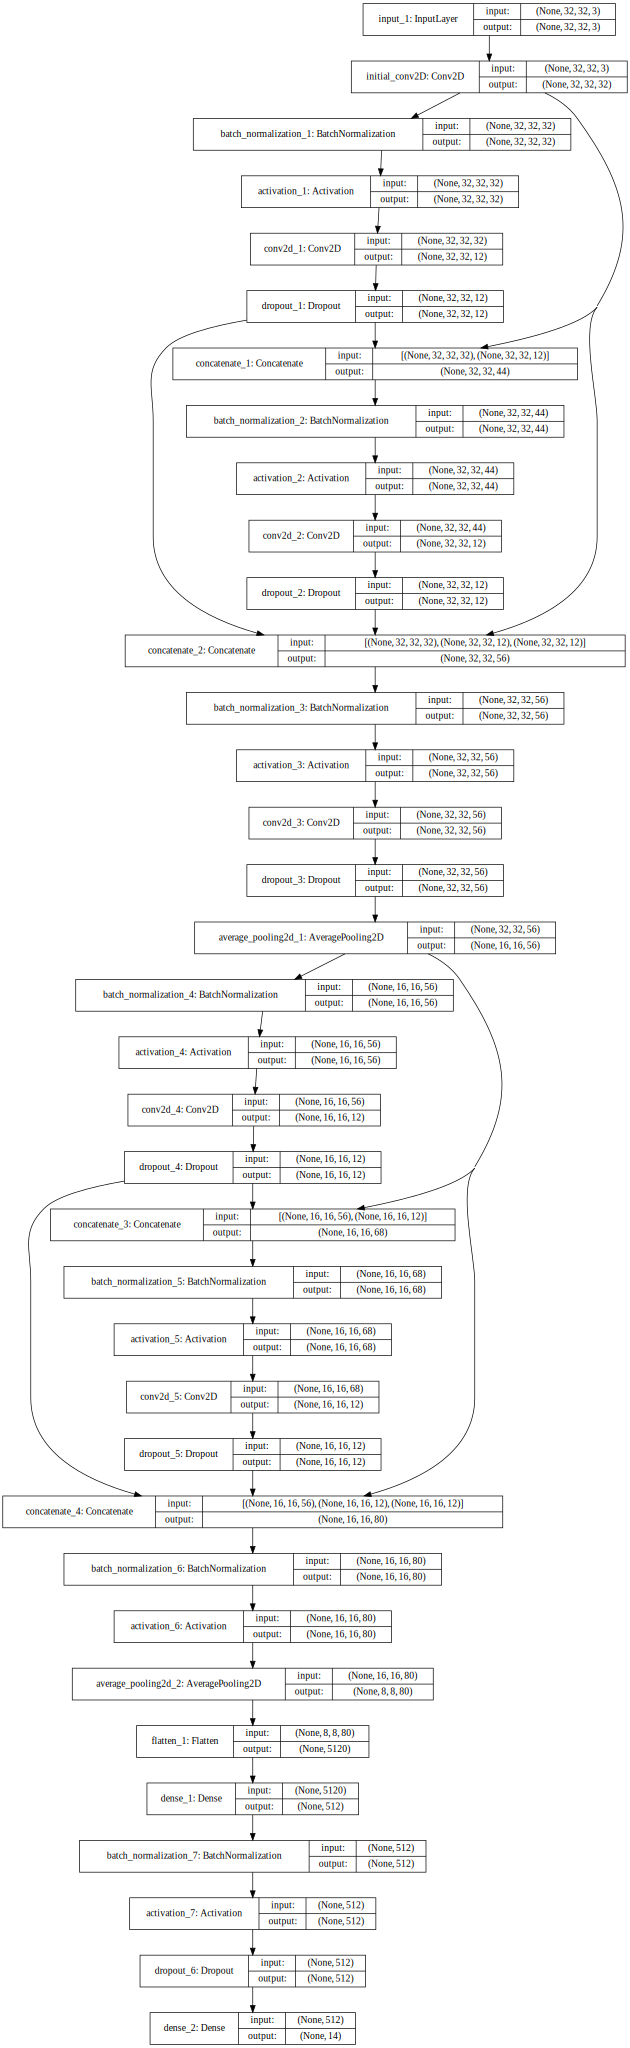

In [21]:
SVG(model_to_dot(cdn, show_shapes=True).create(prog='dot', format='svg'))

In [31]:
%%time

epochs = 10

history = cdn.fit(X,y,epochs=epochs,batch_size=64,verbose=1)

Epoch 1/1
20000/20000 [==============================] - 1027s - loss: 0.1154  
CPU times: user 39min 16s, sys: 2min 5s, total: 41min 22s
Wall time: 17min 7s


In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

In [ ]:
%%time

epochs = 10
#5-fold cross validation
score = []
kf = KFold(n_splits=5,shuffle=True)
for train,val in kf.split(X, y):
    cdn=getCutmoizedDenseNet()
    cdn.compile(loss='binary_crossentropy', optimizer='adam')
    cdn.fit(X[train],y[train],epochs=epochs,batch_size=64,verbose=1)
    y_train_pred = cdn.predict(X[train],batch_size=32, verbose=1)
    threshold=getThreshold(y_train_pred,y[train],0.001)
    y_val_pred = 1*(cdn.predict(X[val],batch_size=32, verbose=1)>threshold)    
    score.append(f1_score(y[val], y_val_pred, average='micro'))
    print("F1 Score:",score[-1])

Epoch 1/10
16000/16000 [==============================] - 281s - loss: 0.2329   
Epoch 2/10
16000/16000 [==============================] - 277s - loss: 0.1952   
Epoch 3/10
16000/16000 [==============================] - 282s - loss: 0.1828   
Epoch 4/10
16000/16000 [==============================] - 282s - loss: 0.1740   
Epoch 5/10
16000/16000 [==============================] - 285s - loss: 0.1653   
Epoch 6/10
16000/16000 [==============================] - 282s - loss: 0.1576   
Epoch 7/10
16000/16000 [==============================] - 284s - loss: 0.1498   
Epoch 8/10
16000/16000 [==============================] - 286s - loss: 0.1415   
Epoch 9/10
16000/16000 [==============================] - 283s - loss: 0.1304   
Epoch 10/10
16000/16000 [==============================] - 162s   
Best threshold for class 0 ： 0.037
Best threshold for class 1 ： 0.118
Best threshold for class 2 ： 0.145
Best threshold for class 3 ： 0.306
Best threshold for class 4 ： 0.141
Best threshold for class 5 ： 

In [13]:
print("F1 Score:", np.mean(score),"+/-", np.std(score))

F1 Score: 0.391927166656 +/- 0.00909683877711


#### Classic ConvNet

In [14]:
def getConvNet():
    K.clear_session()
    model=Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3),padding='same', input_shape=X.shape[1:],activation="relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3),activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_class))
    model.add(Activation("sigmoid"))
    return model

In [15]:
cn=getConvNet()
cn.compile(loss='binary_crossentropy',optimizer='adam')
print(cn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [ ]:
%%time

epochs = 3

history = cn.fit(X,y,epochs=epochs,batch_size=64,verbose=1)

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

In [16]:
%%time


epochs = 10
#5-fold cross validation
score = []
kf = KFold(n_splits=5,shuffle=True)
for train,val in kf.split(X, y):
    cn=getConvNet()
    cn.compile(loss='binary_crossentropy', optimizer='adam')
    cn.fit(X[train],y[train],epochs=epochs,batch_size=64,verbose=1)
    y_train_pred = cn.predict(X[train],batch_size=32, verbose=1)
    threshold=getThreshold(y_train_pred,y[train],0.001)
    y_val_pred = 1*(cn.predict(X[val],batch_size=32, verbose=1)>threshold)    
    score.append(f1_score(y[val], y_val_pred, average='micro'))
    print("F1 Score:",score[-1])

Epoch 1/10
16000/16000 [==============================] - 31s - loss: 0.2453    
Epoch 2/10
16000/16000 [==============================] - 30s - loss: 0.2013    
Epoch 3/10
16000/16000 [==============================] - 29s - loss: 0.1922    
Epoch 4/10
16000/16000 [==============================] - 30s - loss: 0.1862    
Epoch 5/10
16000/16000 [==============================] - 31s - loss: 0.1823    
Epoch 6/10
16000/16000 [==============================] - 31s - loss: 0.1787    
Epoch 7/10
16000/16000 [==============================] - 29s - loss: 0.1766    
Epoch 8/10
16000/16000 [==============================] - 31s - loss: 0.1740    
Epoch 9/10
16000/16000 [==============================] - 30s - loss: 0.1708    
Epoch 10/10
15936/16000 [============================>.] - ETA: 0sBest threshold for class 0 ： 0.191
Best threshold for class 1 ： 0.184
Best threshold for class 2 ： 0.255
Best threshold for class 3 ： 0.38
Best threshold for class 4 ： 0.214
Best threshold for class 5 ： 0.

In [17]:
print("F1 Score:", np.mean(score),"+/-", np.std(score))

F1 Score: 0.355676373213 +/- 0.00813702126318


#### What if we just guess the label according to the probability of zero and one of each label.......

In [49]:
random=np.zeros((N,num_class))
for i in range(num_class):
    p_0=(y[:,i]==0).sum()/N
    random[:,i] = np.random.choice([0,1], N, p=[p_0, 1-p_0])

print("The score of random guess:",f1_score(y,random, average='micro'))

The score of random guess: 0.181511437503


## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [ ]:
#model = cdn
model.save('model.h5')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Download test set

In [ ]:
testset_path = 'test/'

dl_file='dl2017-image-test.zip'
dl_url='https://www.cs.helsinki.fi/u/mvsjober/misc/'
get_file(dl_file, dl_url+dl_file, cache_dir='./', cache_subdir=testset_path, extract=True)

In [ ]:
img_test_list = [testset_path+"images/"+"im"+str(x)+".jpg" for x in range(20001,250001)]
X_test = np.stack([image_load_func(file) for file in img_test_list])
print(X_test.shape)

## Predict for test set

You will be asked to return your prediction for the testset.  These should be returned as a matrix with one row for each test set image.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
If you have the matrix prepared in `y` (e.g., by calling `y=model.predict(x_test)`) you can use the following function to save it to a text file.

In [ ]:
model = cdn
y_pred_raw = model.predict(X,batch_size=32, verbose=1)
threshold=getThreshold(y_pred_raw,y,0.001)
y_pred = 1*(y_pred_raw>threshold)    
#print("F1 score :",f1_score(y, y_pred, average='micro'))

In [ ]:
np.savetxt('results.txt', y_pred, fmt='%d')

## Documentation and Disscussion

Original DenseNet with 32 filters each layer, 3 dense blocks,2 layers each block,0.2 dropout rate and 12 growth rate
 0.232187499321 +/- 0.0173297726876
 
 - Original DenseNet : a dead end. Several reason: designed to serve a different purpose: multi-class. not enough time to get fully trained, imbalanced data.
 